In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [3]:
import sys
sys.path.insert(0, '../src/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import tensorflow as tf
import PIL
from IPython.display import HTML

from dip.models import hour_glass, get_dip_model, get_dd_model
from dip.utils import read_img, gauss_noise, psnr
from dip.trainer import train
from dip.vis import plot_training

LOG = 10
NITER = 5000

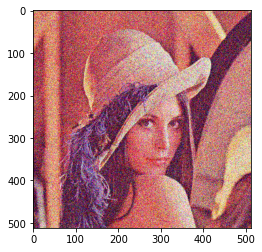

In [11]:
lena = read_img('../imgs/lena.png')
lena_n, mask = gauss_noise(lena, 0.25)

dip_lena = get_dip_model(lena_n.shape, mask)
dd_lena = get_dd_model((16, 16, 3), mask)

z_dip = np.expand_dims(np.random.randn(*lena.shape), 0)
z_dd = np.expand_dims(np.random.randn(16, 16, 3), 0)

plt.imshow(lena_n)

In [ ]:
dip_history = train(dip_lena, NITER, lena_n, z=z_dip, log=LOG)

In [ ]:
dd_history = train(dd_lena, NITER, lena_n, z=z_dd, log=LOG)

0: 0.16150712966918945


/Users/cem/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100: nan


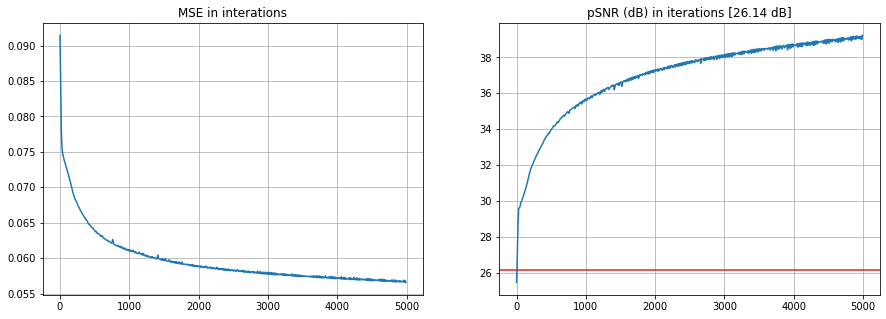

In [9]:
plot_training([dd_history], LOG, lena, lena_n);

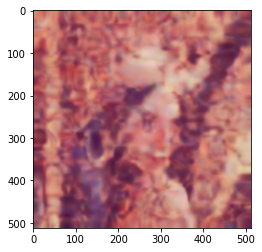

In [10]:
plt.imshow(dd_history[-1][-1])

In [ ]:
n_frames = len(history[-1])
n_sec = 16
fps = n_frames / n_sec

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(21, 9))
im2 = axs[1].imshow(history[-1][0])

ln1 = axs[0].plot([], [])[0]
ax0_1 = axs[0].twinx()
ln2 = ax0_1.plot([], [], c='C3')[0]

axs[0].set_xlim(-10, 2010)
axs[0].set_ylim(0, 100)
axs[0].grid()
ax0_1.set_ylim(0, 0.1)

def init():
    im2.set_data(history[-1][0])
    ln1.set_data([], [])
    ln2.set_data([], [])
    return [ln1, ln2, im2]

def animate(i):
    im2.set_array(history[-1][i])
    ln1.set_data(iter_nums[:i], epoch_psnr[:i])
    ln2.set_data(iter_nums[:i], epoch_losses[:i])
    return [ln1, im2]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames, interval=1/fps, blit=True)
anim.save('basic_animation.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])